# Figure 3

In [1]:
## Tree figure rendering
import os
from os import path
os.environ['QT_QPA_PLATFORM'] = 'offscreen'

In [2]:
import sys
sys.path.insert(1, '../code/scripts')

In [4]:
## Basics
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import mdtraj as md
import parseaf as pa
#import tempparse as paf

## Logistic regression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499'}

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [6]:
def get_aa_freq(seq, aa):
    cnt = 0
    for i in seq:
        if i == aa:
            cnt += 1
    aa_freq = cnt / len(seq)
    return aa_freq

In [7]:
def append_percent_aa(row, aa):
    seq = row['region_seq']
    if len(seq) == 0:
        print(row['uni_id'])
    return get_aa_freq(seq, aa)

In [8]:
def get_cnf_freq(cnf_mat):
    cnf_freq = cnf_mat / cnf_mat.sum(axis=1)[:, np.newaxis]
    return cnf_freq

## Data

In [9]:
allregions = pd.read_csv('../data/af_regions/sc_af_regions_all.csv')

In [10]:
cnf_df = pd.read_csv('../misc/cp_cnf_matrices.csv')

## 3A: Logistic regression model coefficients

In [11]:
states = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [12]:
for aa in states:
    allregions['freq_'+aa] = allregions.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [13]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X = allregions[featurecol]
y = allregions['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
cnf_all = metrics.confusion_matrix(y_test, y_pred)
metrics.accuracy_score(y_test, y_pred)

0.9246841593780369

In [14]:
df_lr = pd.DataFrame(columns=['aa','coef'])
for i in range(20):
    df_lr = df_lr.append({'aa': states[i], 'coef': logreg.coef_[0][i]}, ignore_index=True)
df_lr = df_lr.sort_values(by='coef', ascending=False, key=abs)

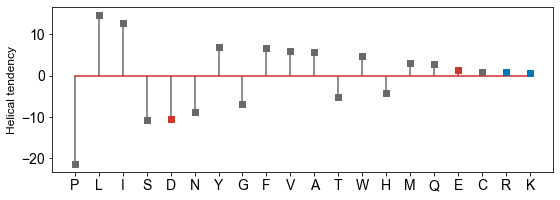

In [15]:
plt.figure(figsize=(8,3))
plt.stem(df_lr['aa'], df_lr['coef'],
         linefmt='dimgrey')

for index,row in df_lr.iterrows():
    aa = row['aa']
    if aa == 'K' or aa == 'R':
        color = cscheme['pos']
    elif aa == 'D' or aa == 'E':
        color = cscheme['neg']
    else:
        color = 'dimgrey'
    plt.scatter(aa, row['coef'], marker='s', color=color, zorder=3)
    
plt.ylabel('Helical tendency', fontsize=12)
plt.tight_layout()
plt.show()

## 3B: LR coefficients against helix propensity

In [16]:
df_hp = pd.read_csv('../data/misc/helix_propensity_pace1998.txt')
h_propensity = {}
for index, row in df_hp.iterrows():
    h_propensity[row['aa']] = row['hp']

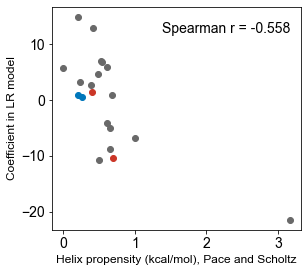

In [23]:
plt.figure(figsize=(4.5,4))

coefs = logreg.coef_.tolist()[0]
for i in range(20):
    aa = states[i]
    if aa == 'K' or aa == 'R':
        color = cscheme['pos']
    elif aa == 'D' or aa == 'E':
        color = cscheme['neg']
    else:
        color = 'dimgrey'
    plt.scatter(h_propensity[aa], coefs[i],
                color=color, zorder=3)

plt.xlabel('Helix propensity (kcal/mol), Pace and Scholtz', fontsize=12)
plt.ylabel('Coefficient in LR model', fontsize=12)
corr = stats.spearmanr(list(h_propensity.values()), logreg.coef_[0].tolist())
plt.text(1.38, 12, "Spearman r = " + '{0:.3g}'.format(corr.correlation))
plt.tight_layout()
#plt.savefig('./fig.png', dpi=300)
plt.show()

## 3C: Uversky plot for all regions

In [24]:
df = pd.read_csv('../data/uversky/uversky_all.csv')

In [18]:
df

,region_seq,start,end,uni_id,len_region,label,norm_hydrop,norm_nc,uversky_pred,uversky_correctness
0,VQDLKQLLLNVFNTYKLERSLSELIQKIIEDSSQDLVQQYRKF,1143,1185,P39702,43,helix,0.453488,0.139535,disordered,0
1,KEDIEKMVAEAEKFKEEDEKESQRIASKNQLESIAYSLKNTISE,508,551,P10591,44,helix,0.368434,0.000000,disordered,0
2,DIIANNAVEEIDRNLNKITKTLNYLRAREWRNMSTVNSTESRLTWL...,138,208,P39704,71,helix,0.549296,0.070423,helix,1
3,KQMFLGSLFGVVLGVTVAKISILFMYVGITSMLLCEWLRY,103,142,P18411,40,helix,0.642500,0.050000,helix,1
4,PASMIFRNLLILEDDLRRQAHEQKILKWQFTLFLASMAGVGAFTFYELY,45,93,P18410,49,helix,0.522676,0.081633,helix,1
...,...,...,...,...,...,...,...,...,...,...
16459,KGHIGDQELPPEEDPSRELNNVQHEVNSLTEQD,211,243,P03871,33,disordered,0.328620,0.030303,disordered,1
16460,DVSTFRRVCSKENDIIKLALRIPRTIDYTSILRLLYDTLPLRSLSF...,25,86,Q06891,62,disordered,0.501792,0.177419,helix,0
16461,IYDRTCYPSLNFEHPNLGVFPETDSIFEPV,151,180,Q06891,30,disordered,0.467778,0.000000,helix,0
16462,MDDIETAKNLTVKARTAYSVWDVCRLFIEMIAPDVDIDIESKRKSD...,0,121,P03872,122,disordered,0.480146,0.122951,helix,0


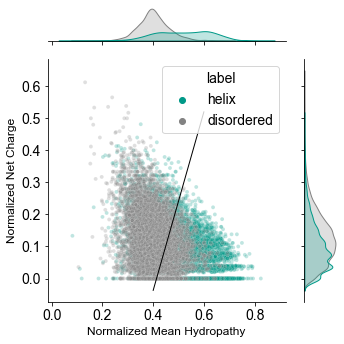

In [40]:
#plt.figure(figsize=(3,3))
g = sns.jointplot(data=df, x='norm_hydrop', y='norm_nc', hue='label',
                  palette={'disordered': cscheme['dis'], 'helix': cscheme['helix']},
                  alpha=0.25, s=15, height=5)
x = np.linspace(0.4,0.6,100)
y = 2.785*x - 1.151
g.ax_joint.plot(x, y, 'black', linewidth = 1)
g.ax_joint.set_xlabel('Normalized Mean Hydropathy', fontsize=12)
g.ax_joint.set_ylabel('Normalized Net Charge', fontsize=12)
plt.tight_layout()
plt.show()

## 3D: Accuracy of logistic regression model

In [45]:
cnf_matrices = []
sample_size = []
for index, row in cnf_df.iterrows():
    mat = np.array([[row['TN'], row['FP']], [row['FN'], row['TP']]])
    cnf_matrices.append(mat)
    if index < 3:
        sample_size.append(row['n'])

In [46]:
titles = ['All regions\nlabelled under\nstringent conditions',
          'Random regions\nlabelled under\nrelaxed conditions',
          'Highly charged regions\nlabelled under\nrelaxed conditions']
for i, title in enumerate(titles):
    titles[i] = title + '\nn = ' + str(sample_size[i])

In [47]:
cnf_matrices

[array([[2258,  183],
        [ 127, 1548]]),
 array([[2422,  128],
        [ 385,  980]]),
 array([[489,  21],
        [ 74, 199]]),
 array([[7698, 1884],
        [2181, 4701]]),
 array([[1948,  602],
        [ 529,  836]]),
 array([[510,   0],
        [271,   2]])]

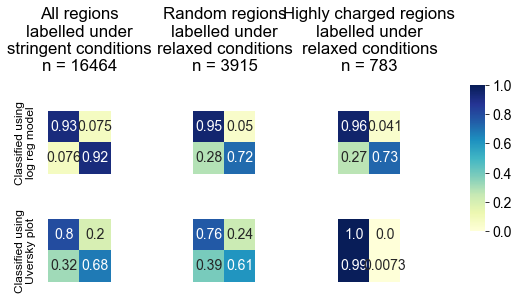

In [50]:
fig, axes = plt.subplots(2,3, figsize=(7, 4.5))
cbar_ax = fig.add_axes([1, .25, .03, .45])

for i, ax in enumerate(axes.flat):
    g = sns.heatmap(pd.DataFrame(get_cnf_freq(cnf_matrices[i])), ax=ax,
                    square=True, annot=True, fmt=".2",
                    xticklabels=['', ''], yticklabels=['', ''],
                    cmap="YlGnBu", cbar= (i == 0),
                    vmin=0, vmax=1,
                    cbar_ax=None if i else cbar_ax)
    g.tick_params(left=False, bottom=False)
    if i < 3:
        g.set_title(titles[i], y=1.2)
    #ax.title.set_position([.5, 0.8])
    if i == 0:
        ax.set_ylabel('Classified using\nlog reg model', fontsize=12)
        ax.yaxis.labelpad = 5
    elif i == 3:
        ax.set_ylabel('Classified using\nUversky plot', fontsize=12)
        ax.yaxis.labelpad = 5
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()

## 3E: Summary of prediction accuracy for 3D

In [51]:
l_acc = []
for i in range(6):
    cnf = cnf_matrices[i]
    accuracy = (cnf[0, 0] + cnf[1, 1]) / np.sum(cnf)
    l_acc.append(accuracy)
sc_acc = np.mean(l_acc[:3])

In [52]:
ticks = ['Using LR model\nto classify all regions',
         'Using LR model\nto classify random regions',
         'Using LR model\nto classify highly charged regions',
         'Using Uverskey plot\nto classify all regions',
         'Using Uverskey plot\nto classify random regions',
         'Using Uverskey plot\nto classify highly charged regions']

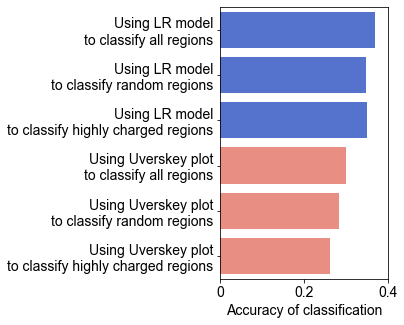

In [53]:
fig, ax = plt.subplots(figsize=(3,5))
ax = sns.barplot(y=ticks, x=l_acc,
                 palette=['royalblue', 'royalblue', 'royalblue', 'salmon', 'salmon', 'salmon'])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xlim(0, 1)
ax.set_xlabel('Accuracy of classification')
plt.show()

## 3F: Prediction accuracy for other training or testing data

In [54]:
d_acc = {'sc_top5': 0.8965014577259475,
 'sc_onlyP': 0.7468415937803693,
 'sc_onlyPG': 0.7560738581146744,
 'pombe': 0.9080121057661675,
 'human': 0.9397504456327985}

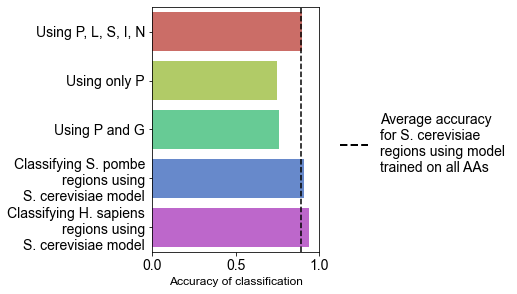

In [55]:
fig, ax = plt.subplots(figsize=(3,4.5))
keys = list(d_acc.keys())
vals = [d_acc[k] for k in keys]
ax = sns.barplot(y=keys, x=vals, palette="hls")
ax.set_yticklabels(['Using P, L, S, I, N', 'Using only P', 'Using P and G',
                    'Classifying S. pombe\nregions using\nS. cerevisiae model',
                    'Classifying H. sapiens\nregions using\nS. cerevisiae model'])
ax.set_xlabel('Accuracy of classification', fontsize=12)
ax.set_xlim(0, 1)
plt.axvline(sc_acc, color='black', linestyle='dashed')
plt.legend([Line2D([0], [0], color='black', lw=2, ls='dashed')],
           ['Average accuracy\nfor S. cerevisiae\nregions using model\ntrained on all AAs'],
          bbox_to_anchor=(1.05, 0.62), frameon=False)
plt.show()

## 3G: Time Tree

In [56]:
from Bio import Phylo
from ete3 import Tree, NodeStyle, TreeStyle

ModuleNotFoundError: No module named 'ete3'

In [57]:
t = Tree('../data/misc/timetree.nwk', format=1)

NameError: name 'Tree' is not defined

In [31]:
for n in t.traverse("postorder"):
    if len(n.name) > 4:
        n.name = n.name.replace("_", " ")

In [32]:
ts = TreeStyle()
ts.show_leaf_name = True
ts.scale_length = 300

I plan to make this in inkscape instead because for some reason the branches don't align in